In this notebook, I will attempt to incorporate a single function which will train a model for a desired set of inputs and an output. This means the function can be called twice on seperate occasions to find predicitons for sersic index and half radius within seperate architectures. This will hopefully reduce confusion within the bnn as previously it was trying to find links between, f, n, and r when they are seperate variables.

We will start by creating a function which, initialises, pulls the training data, trains the model, and then tests it all in one. 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchbnn as bnn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from torch.utils.data import TensorDataset, DataLoader

#allocating datasets and model to GPU for speed's sake
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
class SeperateOutputBNN(nn.Module):

    def __init__(self, neurons, dropout_prob):

        super(SeperateOutputBNN, self).__init__()
        self.input_layer = nn.Sequential(
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=3, out_features= neurons),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
        )


        self.output_layer = nn.Sequential( #this is the output layer for y0
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=neurons, out_features=neurons),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=neurons, out_features=113)
        )

    def forward(self, input): #this is the forward pass, run automatically when you call the model
        """
        This function performs the forward pass.
        Parameters:
            input (tensor): input tensor.
        
        Returns:
            tensor: output tensor.
        """

        shared = self.input_layer(input)
        output = self.output_layer(shared)
        return output


In [3]:
def initialise_model(neurons: int, dropout_prob: float, lr: float = 0.01) -> tuple:
    """
    Initialise the DualOutputBNN model with its loss functions and optimizer.

    Parameters:
    - no_of_neurones (int): Number of neurons in the hidden layer.
    - dropout_prob (float): Dropout probability.
    - lr (float): Learning rate for the optimizer. Default is 0.01.

    Returns:
    - A tuple containing the initialized model, MSE loss function, KL loss function, KL weight, and optimizer.
    """

    model = SeperateOutputBNN(neurons, dropout_prob).to(device)

    mse_loss = nn.MSELoss().to(device)
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
    kl_weight = 0.01

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("Model initialised")

    return model, mse_loss, kl_loss, kl_weight, optimizer

In [4]:
def train_model(model_attributes, input_train, output_train, epochs: int, batch_size: int):
    """
    Train the model using batch training.

    Parameters:
    - model_attributes (tuple): Tuple containing the initialized model, MSE loss function, KL loss function, KL weight, and optimizer.
    - input_train (tensor): Input tensor for training.
    - output_train (tensor): Output tensor for training.
    - epochs (int): Number of epochs to train the model.
    - batch_size (int): Batch size for training.

    Returns:
    - The trained model.
    """

    model, mse_loss, kl_loss, kl_weight, optimizer = model_attributes
    model = model.train()

    # Create a TensorDataset from input and output tensors
    tensor_dataset = TensorDataset(input_train, output_train)

    # Create a DataLoader for batch training
    data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for batch_data, batch_labels in data_loader:
            optimizer.zero_grad()

            pred = model(batch_data)  # forward pass

            # Calculate MSE loss for each output and KL divergence
            mse = mse_loss(pred, batch_labels)
            kl = kl_loss(model)

            # Calculate cost (MSE + KL)
            cost = mse + kl_weight * kl

            # Backpropagation and optimization
            cost.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs} - cost: {cost.item():.3f}")

        # print the cost at the end of each epoch
    print(f"- cost: {cost.item():.3f}")

    return model

In [5]:
def test_model(model, model_attributes, input_test, output_test):
    """
    Test the model.

    Parameters:
    - model (nn.Module): Trained model.
    - model_attributes (tuple): Tuple containing the initialized model, MSE loss function, KL loss function, KL weight, and optimizer.
    - input_test (tensor): Input tensor for testing.
    - output_test (tensor): Output tensor for testing.

    Returns:
    - mean_results (tensor): Mean of the predictions.
    - std_results (tensor): Standard deviation of the predictions.

    """

    mse_loss, kl_loss, kl_weight = model_attributes[1:4]  # no need for model or optimizer

    model = model.eval().cpu()
    input_test = input_test.cpu()
    output_test = output_test.cpu()

    pred = np.array([model(input_test).detach().numpy() for _ in range(500)]).T


    #for each prediction of row, find mean and standard deviation
    mean_results = np.mean(pred, axis = 2)
    std_results = np.std(pred, axis = 2)

    #find the cost of the model
    mse = mse_loss(torch.unsqueeze(torch.Tensor(mean_results), dim = 1), torch.unsqueeze(torch.Tensor(output_test.T), dim=1))

    kl = kl_loss(model)
    cost = mse + kl_weight * kl

    print(f"- Test Cost: {cost.item():.3f}")

    
    return mean_results, std_results
    

    

In [6]:
def read_params(filename: str, filepath: str = '../../../data/radiative_transfer/input/'):
    """
    Read the parameters from the input file.

    Parameters:
    - filename (str): Name of the input file.
    - filepath (str): Path to the input file. Default is '../../data/radiative_transfer/input/'.

    Returns:
    - table (dict): Dictionary containing the parameters.
    """

    lines = open(filepath+filename, 'r').readlines()

    keys = []
    values = []
    for i in range(len(lines)):

        line_i = lines[i]
        line1 = line_i.split('\n')[0]
        line2 = line1.split('#')[0]
        line3 = line2.split('=')
        line4 = []
        for j in range(len(line3)):
            line4.append( line3[j].strip(' ') )

        if len(line4) == 2:
            keys.append(line4[0])
            line5 = line4[1].split(', ')
            line5 = np.array(line5).astype(float)
            if len(line5) == 1 and line4[0]!='theta':
                line5 = line5[0]
            values.append(line5)

    table = dict(zip(keys, values) )
    return table


In [7]:
def read_h5_file(filename: str, data, thetas, log_mstar, log_mdust_over_mstar, filepath: str = '../../../data/radiative_transfer/output/'):
    """
    Read the output file.

    Parameters:
    - filename (str): Name of the output file.
    - data (pd.DataFrame): DataFrame containing the data.
    - thetas (list): List of viewing angles.
    - log_mstar (float): log of stellar mass.
    - log_mdust_over_mstar (float): log of dust mass over stellar mass.
    - filepath (str): Path to the output file. Default is '../../data/radiative_transfer/output/'.

    Returns:
    - wvl (np.array): Rest-frame wavelength [micron].
    - data (pd.DataFrame): DataFrame containing the data.
    """

    filepath += filename 
    print(filepath)

    # Finding hdf keys
    hdf_keys = np.array([])
    with pd.HDFStore(filepath, 'r') as hdf:
        hdf_keys = np.append(hdf_keys, hdf.keys())

    for i in range(len(hdf_keys)):

        table = pd.read_hdf(filepath, hdf_keys[i]) # Face-on view
        wvl = table['wvl'].to_numpy(dtype=np.float64) # rest-frame wavelength [micron]
        flux = table['flux'].to_numpy(dtype=np.float64) # flux [W/m^2]
        r = table['r'].to_numpy(dtype=np.float64) # half-light radius [kpc]
        n = table['n'].to_numpy(dtype=np.float64) # Sersic index

        #taking the log of flux, r, and n
        flux = np.log10(flux)
        r = np.log10(r)
        n = np.log10(n)

        data = pd.concat([data, pd.DataFrame({"log_mstar": log_mstar, "log_mdust_over_mstar": log_mdust_over_mstar, "theta": thetas[i], "n":[n], "flux":[flux], "r":[r]})], ignore_index=True)

    return wvl, data.reset_index(drop=True)


In [8]:
def read_parameter_files(filenames: list, filepath: str = "../../../data/radiative_transfer/input/"):
    """
    Read the parameter files.

    Parameters:
    - filenames (list): List of filenames.
    - filepath (str): Path to the parameter files. Default is '../../data/radiative_transfer/input/'.

    Returns:
    - list_log_mstar (np.array): Array of log of stellar mass.
    - list_log_mdust_over_mstar (np.array): Array of log of dust mass over stellar mass.
    - list_theta (np.array): Array of viewing angles.
    """
    

    list_log_mstar = np.array([])
    list_log_mdust = np.array([])
    list_theta = np.array([])

    for filename in filenames:
        table = read_params(filename, filepath)
        list_log_mstar = np.append(list_log_mstar, table['logMstar'])
        list_log_mdust = np.append(list_log_mdust, table['logMdust'])
        list_theta = np.append(list_theta, table['theta'])

    list_log_mdust_over_mstar = list_log_mdust - list_log_mstar


    return list_log_mstar, list_log_mdust_over_mstar, list_theta


In [9]:
def generate_dataset(data, params, files):
    """
    Generate the dataset.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the data.
    - params (list): List of parameter files.
    - files (list): List of output files.

    Returns:
    - wavelength (np.array): Rest-frame wavelength [micron].
    - data (pd.DataFrame): DataFrame containing the data.
    """

    list_log_mstar, list_log_mdust_over_mstar, list_theta = read_parameter_files(params)

    #converting theta to radians
    list_theta = (list_theta * np.pi) / 180


    for i in range(len(files)):
        wavelength, data = read_h5_file(files[i], data, np.sin(list_theta), list_log_mstar[i], list_log_mdust_over_mstar[i])


    #function to normalise parameters
    normalise = lambda x: (x - np.mean(x)) / np.std(x)

    #normalising parameters

    data['log_mstar'] = normalise(data['log_mstar'])
    data['log_mdust_over_mstar'] = normalise(data['log_mdust_over_mstar'])
    data['theta'] = normalise(data['theta'])



    return wavelength, data


In [10]:
def split_dataset(parameter_files, h5_files):
    """
    Split the dataset into training and testing sets.

    Parameters:
    - parameter_files (list): List of parameter files.
    - h5_files (list): List of output files.

    Returns:
    - input_train (list): List of input tensors for training.
    - input_test (list): List of input tensors for testing.
    - output_train (list): List of output tensors for training.
    - output_test (list): List of output tensors for testing.
    """

    # Split the dataset into training and testing sets
    df = pd.DataFrame({"parameter_files": parameter_files, "h5_files": h5_files})
    #using random state for reproducibility of 64
    train, test = train_test_split(df, test_size=0.2, random_state=64)

    # Convert the training and testing sets to lists
    input_train = train['parameter_files'].to_list()
    input_test = test['parameter_files'].to_list()
    output_train = train['h5_files'].to_list()
    output_test = test['h5_files'].to_list()

    return input_train, input_test, output_train, output_test

In [11]:
def convert_to_tensor(data):
    """
    Convert the DataFrame to a tensor.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the data.

    Returns:
    - data (tensor): Tensor containing the data.
    """

    data = data.applymap(np.array)
    stacked_input_arrays = np.stack(data.apply(lambda row: np.stack(row, axis=0), axis=1).to_numpy())
    data = torch.Tensor(stacked_input_arrays).to(device)

    return data


In [12]:
#obtaining logs of stellar mass, and ratio of dust to stellar mass
parameter_files = [file for file in os.listdir("../../../data/radiative_transfer/input/") if file.startswith("parameters")]
h5_files = [file for file in os.listdir("../../../data/radiative_transfer/output/") if file.startswith("data")]


# splitting the dataset into training and testing sets by filename - this is to ensure every inclination of a run is in the same set
# parameter_train, parameter_test, h5_train, h5_test = train_test_split(parameter_files, h5_files, test_size=0.2, random_state=0)
parameter_train, parameter_test, h5_train, h5_test = split_dataset(parameter_files, h5_files)

wavelength, h5_train_data = generate_dataset(pd.DataFrame(columns=["log_mstar", "log_mdust_over_mstar", "theta", "n", "flux", "r"]), parameter_train, h5_train)
wavelength, h5_test_data = generate_dataset(pd.DataFrame(columns=["log_mstar", "log_mdust_over_mstar", "theta", "n", "flux", "r"]), parameter_test, h5_test)

#split training and testing sets into inputs and outputs
train_inputs, train_outputs = h5_train_data[["log_mstar", "log_mdust_over_mstar", "theta"]], h5_train_data[["n", "flux", "r"]]
test_inputs, test_outputs = h5_test_data[["log_mstar", "log_mdust_over_mstar", "theta"]], h5_test_data[["n", "flux", "r"]]

#convert training and testing data into numpy arrays
train_inputs, test_inputs = train_inputs.to_numpy(), test_inputs.to_numpy()
train_inputs, test_inputs = torch.Tensor(train_inputs).to(device), torch.Tensor(test_inputs).to(device)

train_outputs, test_outputs = convert_to_tensor(train_outputs).to(device), convert_to_tensor(test_outputs).to(device)

../../../data/radiative_transfer/output/data96.h5


C:\Users\joshu\AppData\Local\Temp\ipykernel_12784\282167750.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame({"log_mstar": log_mstar, "log_mdust_over_mstar": log_mdust_over_mstar, "theta": thetas[i], "n":[n], "flux":[flux], "r":[r]})], ignore_index=True)


../../../data/radiative_transfer/output/data54.h5
../../../data/radiative_transfer/output/data19.h5
../../../data/radiative_transfer/output/data12.h5
../../../data/radiative_transfer/output/data71.h5
../../../data/radiative_transfer/output/data59.h5
../../../data/radiative_transfer/output/data83.h5
../../../data/radiative_transfer/output/data81.h5
../../../data/radiative_transfer/output/data34.h5
../../../data/radiative_transfer/output/data30.h5
../../../data/radiative_transfer/output/data17.h5
../../../data/radiative_transfer/output/data75.h5
../../../data/radiative_transfer/output/data35.h5
../../../data/radiative_transfer/output/data74.h5
../../../data/radiative_transfer/output/data60.h5
../../../data/radiative_transfer/output/data87.h5
../../../data/radiative_transfer/output/data67.h5
../../../data/radiative_transfer/output/data8.h5
../../../data/radiative_transfer/output/data61.h5
../../../data/radiative_transfer/output/data99.h5
../../../data/radiative_transfer/output/data20.h5
.

C:\Users\joshu\AppData\Local\Temp\ipykernel_12784\282167750.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame({"log_mstar": log_mstar, "log_mdust_over_mstar": log_mdust_over_mstar, "theta": thetas[i], "n":[n], "flux":[flux], "r":[r]})], ignore_index=True)


../../../data/radiative_transfer/output/data92.h5
../../../data/radiative_transfer/output/data3.h5
../../../data/radiative_transfer/output/data26.h5
../../../data/radiative_transfer/output/data73.h5
../../../data/radiative_transfer/output/data94.h5
../../../data/radiative_transfer/output/data45.h5
../../../data/radiative_transfer/output/data53.h5
../../../data/radiative_transfer/output/data9.h5
../../../data/radiative_transfer/output/data1.h5
../../../data/radiative_transfer/output/data84.h5
../../../data/radiative_transfer/output/data11.h5
../../../data/radiative_transfer/output/data95.h5
../../../data/radiative_transfer/output/data36.h5
../../../data/radiative_transfer/output/data13.h5
../../../data/radiative_transfer/output/data5.h5
../../../data/radiative_transfer/output/data10.h5
../../../data/radiative_transfer/output/data57.h5


C:\Users\joshu\AppData\Local\Temp\ipykernel_12784\1033682988.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(np.array)


In [13]:
def run_BNN(neurons,dropout_prob,lr,train_inputs,train_outputs,epochs,batch_size, test_inputs, test_outputs):

    model_attributes = initialise_model(neurons, dropout_prob, lr)
    trained_model = train_model(model_attributes, train_inputs, train_outputs, epochs, batch_size)
    mean_results, std_results = test_model(trained_model, model_attributes, test_inputs, test_outputs)
    test_outputs = test_outputs.cpu().numpy()

    return mean_results, std_results

    

In [14]:
mean_n_results, std_n_results = run_BNN(1000, 0.3, 0.01, train_inputs, train_outputs[:,0,:], 250 , 32, test_inputs, test_outputs[:,0,:] )





#dropout_prob, input_train, output_train, epochs, lr, neurons, input_test, output_test




Model initialised
Epoch 1/250 - cost: 0.125
Epoch 2/250 - cost: 0.099
Epoch 3/250 - cost: 0.079
Epoch 4/250 - cost: 0.068
Epoch 5/250 - cost: 0.062
Epoch 6/250 - cost: 0.068
Epoch 7/250 - cost: 0.057
Epoch 8/250 - cost: 0.059
Epoch 9/250 - cost: 0.064
Epoch 10/250 - cost: 0.047
Epoch 11/250 - cost: 0.055
Epoch 12/250 - cost: 0.068
Epoch 13/250 - cost: 0.065
Epoch 14/250 - cost: 0.056
Epoch 15/250 - cost: 0.050
Epoch 16/250 - cost: 0.048
Epoch 17/250 - cost: 0.057
Epoch 18/250 - cost: 0.056
Epoch 19/250 - cost: 0.046
Epoch 20/250 - cost: 0.045
Epoch 21/250 - cost: 0.045
Epoch 22/250 - cost: 0.040
Epoch 23/250 - cost: 0.044
Epoch 24/250 - cost: 0.051
Epoch 25/250 - cost: 0.047
Epoch 26/250 - cost: 0.049
Epoch 27/250 - cost: 0.051
Epoch 28/250 - cost: 0.069
Epoch 29/250 - cost: 0.043
Epoch 30/250 - cost: 0.049
Epoch 31/250 - cost: 0.043
Epoch 32/250 - cost: 0.045
Epoch 33/250 - cost: 0.046
Epoch 34/250 - cost: 0.034
Epoch 35/250 - cost: 0.043
Epoch 36/250 - cost: 0.046
Epoch 37/250 - cost

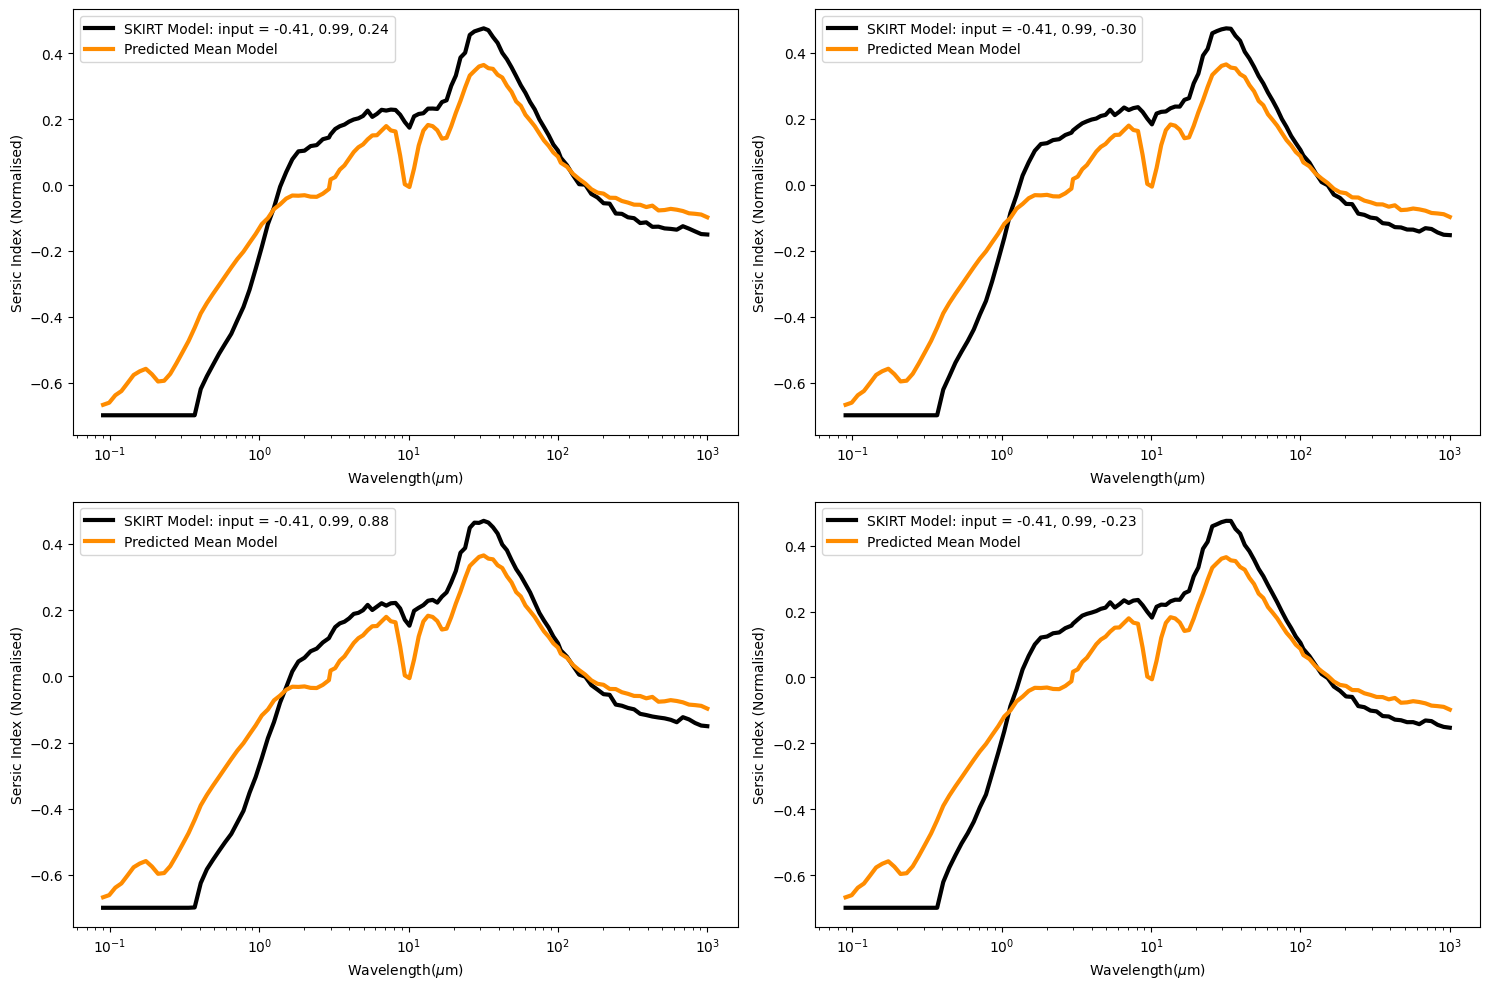

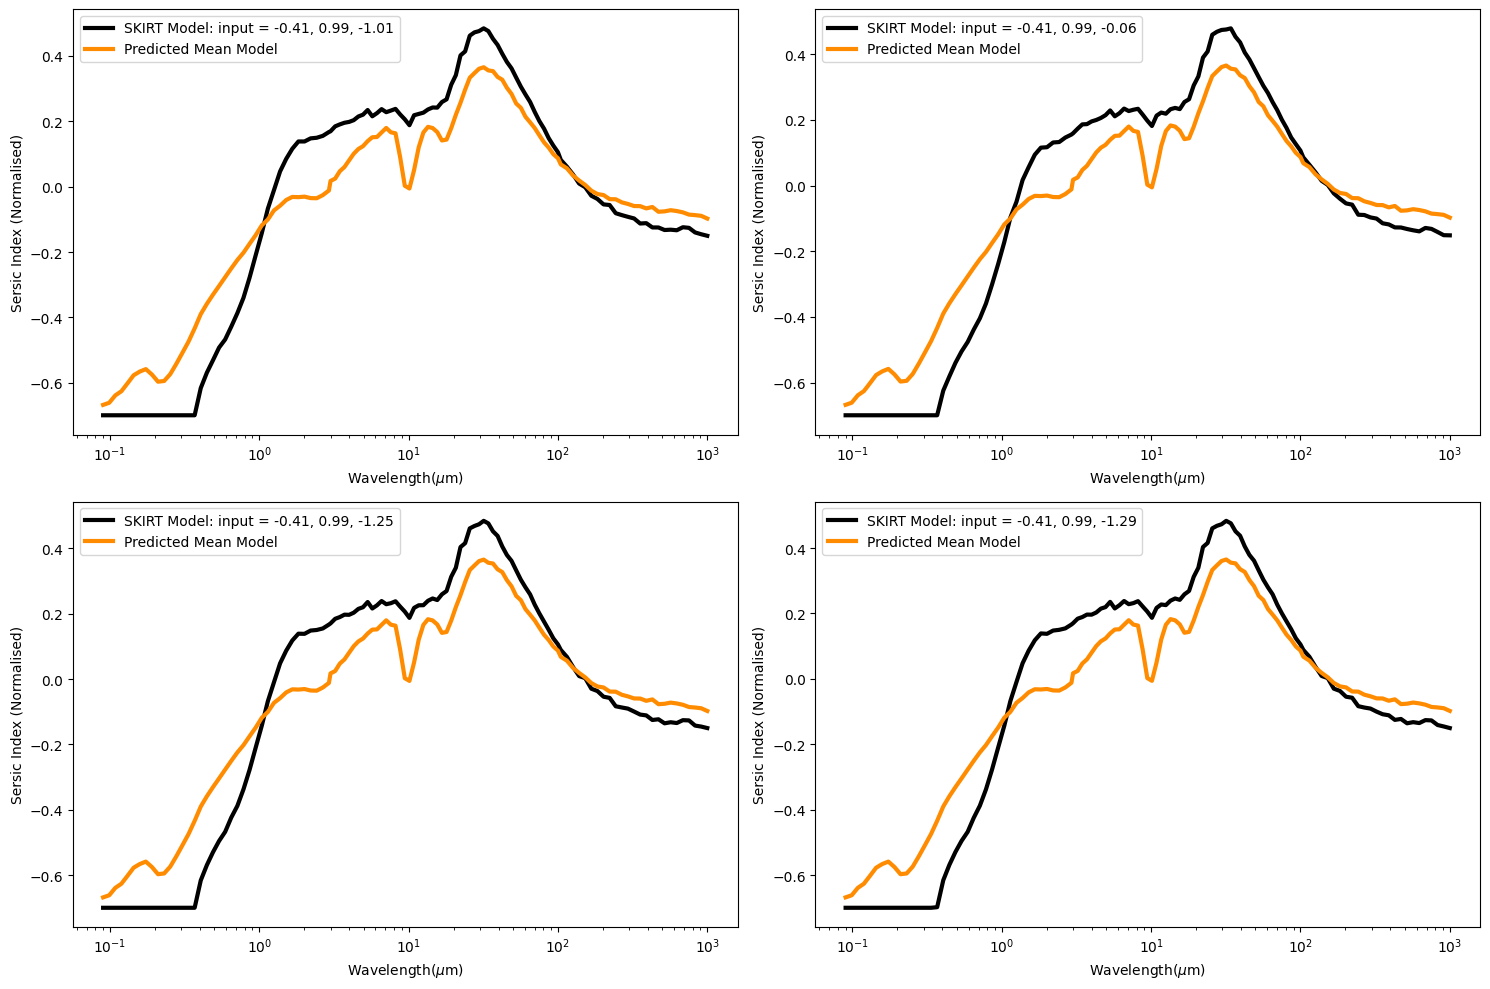

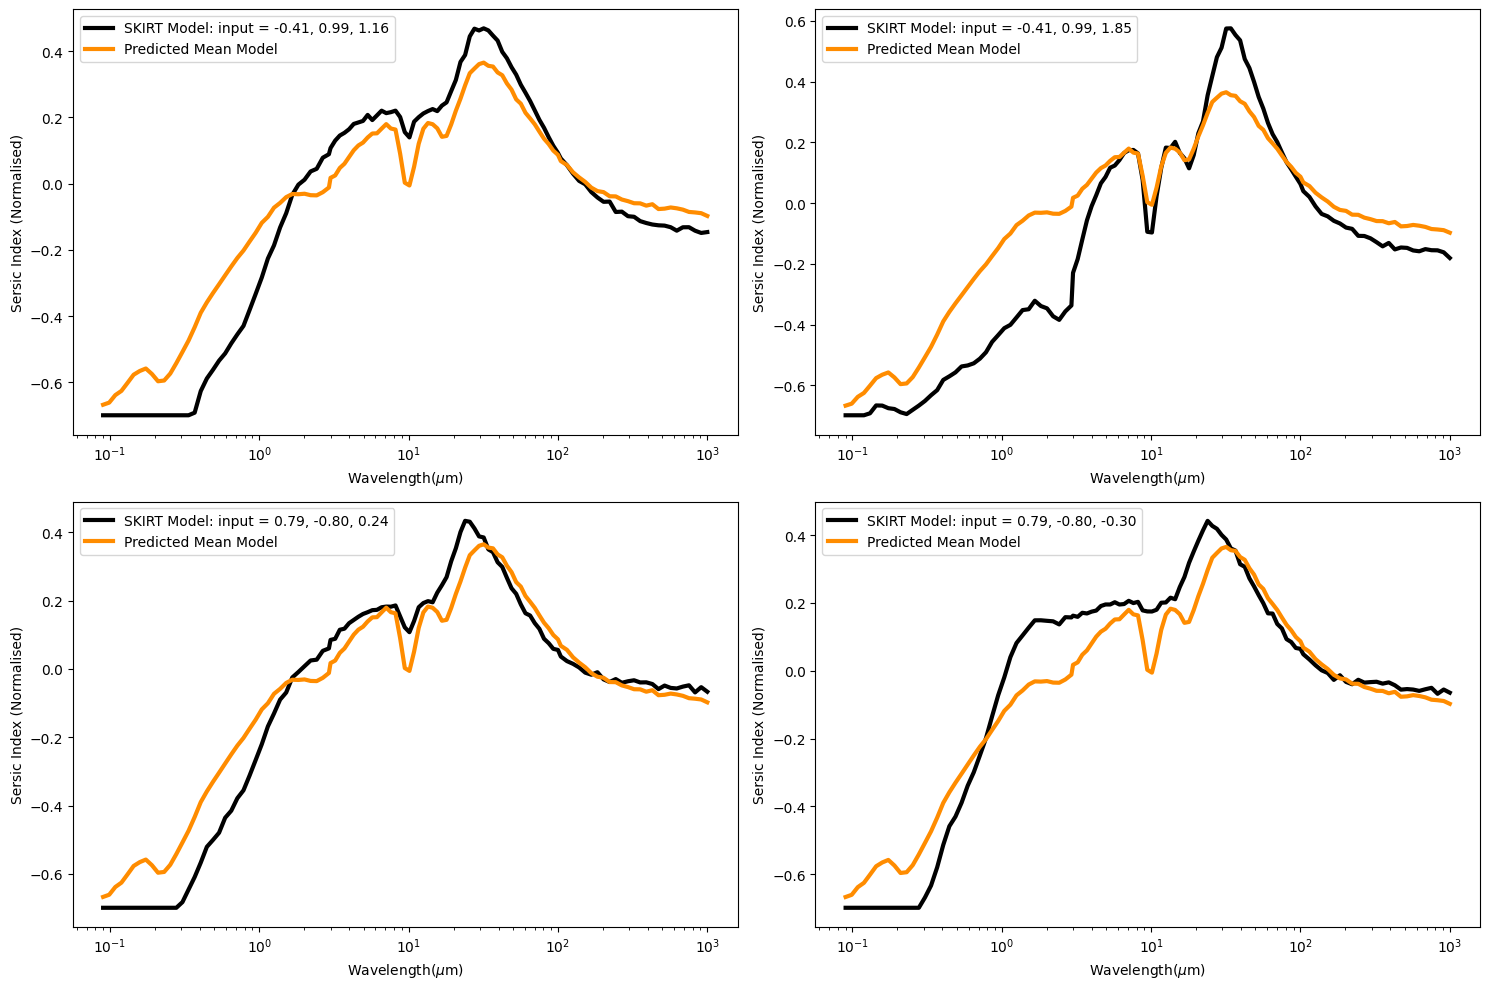

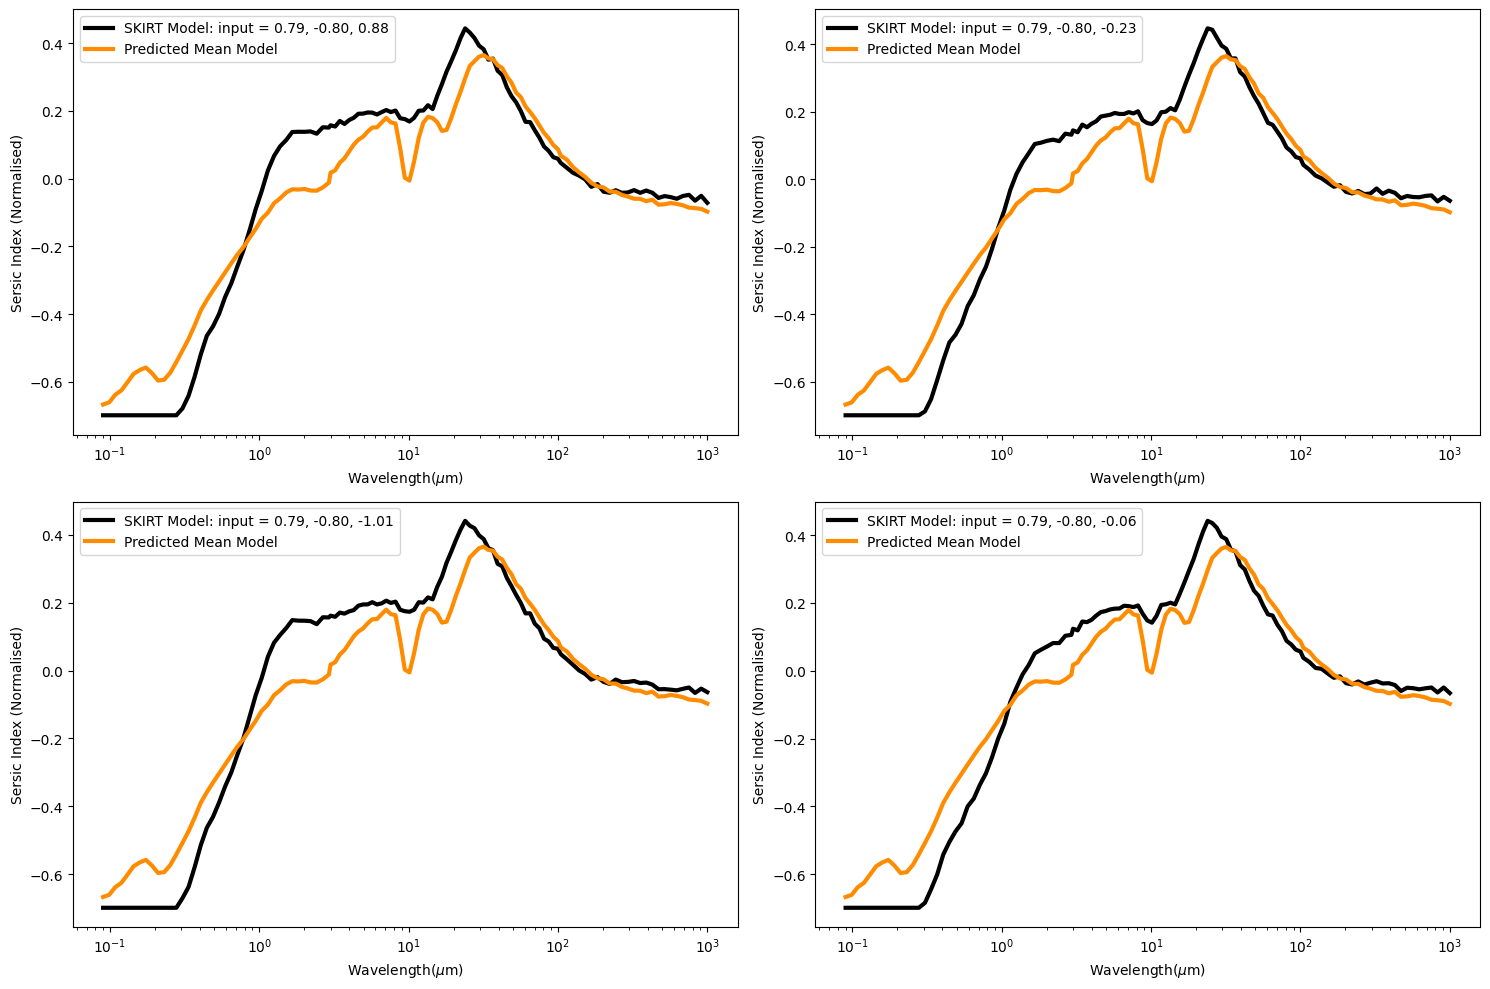

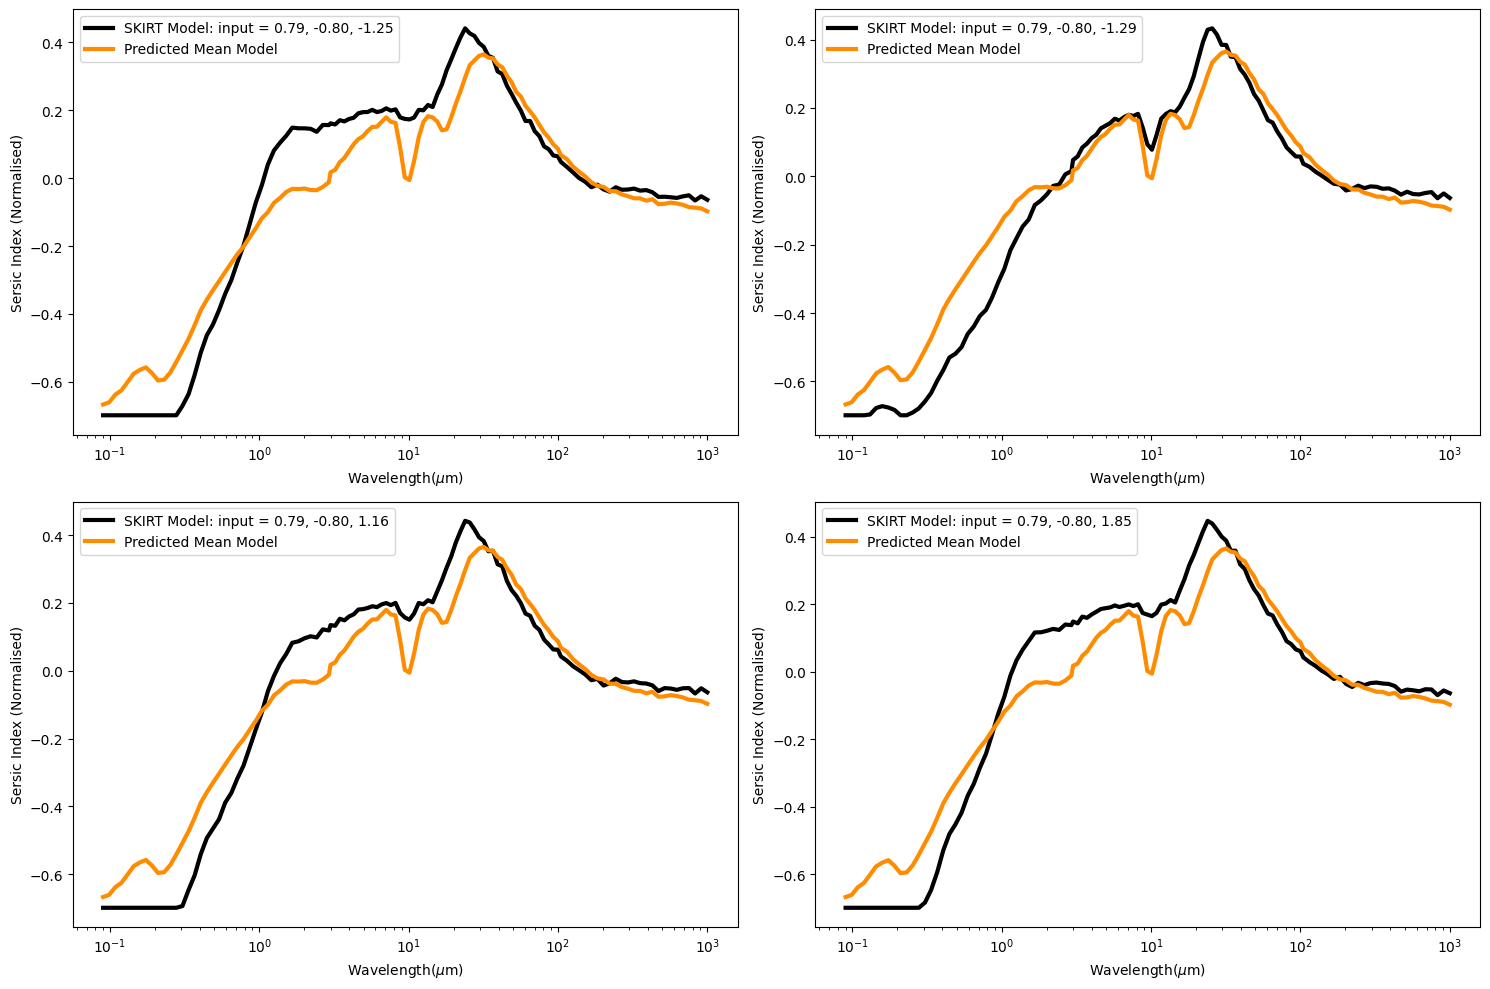

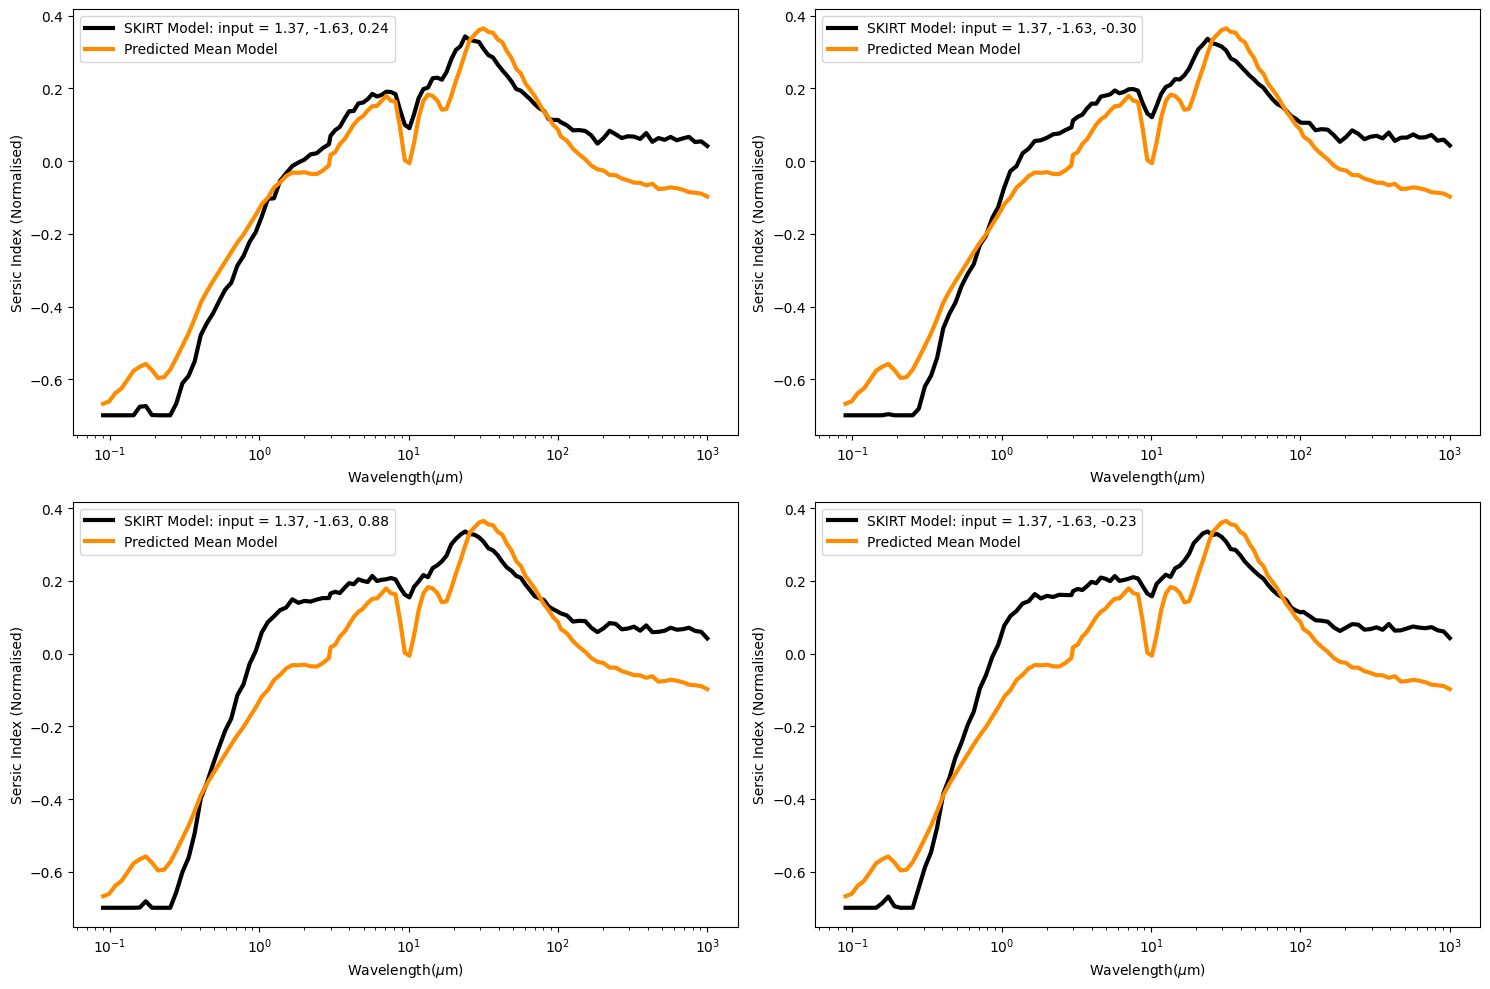

In [15]:
i = 0

while i <24:

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    ax1.plot(wavelength,test_outputs[i,0,:],color='black',lw=3,label=f'SKIRT Model: input = {test_inputs[i,0]:2.2f}, {test_inputs[i,1]:2.2f}, {test_inputs[i,2]:2.2f}')
    ax1.plot(wavelength,mean_n_results[:,i],color='darkorange',lw=3,label='Predicted Mean Model')
    ax2.plot(wavelength,test_outputs[i+1,0,:],color='black',lw=3,label=f'SKIRT Model: input = {test_inputs[i+1,0]:2.2f}, {test_inputs[i+1,1]:2.2f}, {test_inputs[i+1,2]:2.2f}')
    ax2.plot(wavelength,mean_n_results[:,i+1],color='darkorange',lw=3,label='Predicted Mean Model')
    ax3.plot(wavelength,test_outputs[i+2,0,:],color='black',lw=3,label=f'SKIRT Model: input = {test_inputs[i+2,0]:2.2f}, {test_inputs[i+2,1]:2.2f}, {test_inputs[i+2,2]:2.2f}')
    ax3.plot(wavelength,mean_n_results[:,i+2],color='darkorange',lw=3,label='Predicted Mean Model')
    ax4.plot(wavelength,test_outputs[i+3,0,:],color='black',lw=3,label=f'SKIRT Model: input = {test_inputs[i+3,0]:2.2f}, {test_inputs[i+3,1]:2.2f}, {test_inputs[i+3,2]:2.2f}')
    ax4.plot(wavelength,mean_n_results[:,i+3],color='darkorange',lw=3,label='Predicted Mean Model')


    for ax in fig.get_axes():
        #ax.label_outer()
        ax.set(xlabel=f'Wavelength($\\mu$m)', ylabel='Sersic Index (Normalised)')
        ax.set_xscale('log')
        ax.legend()


    plt.tight_layout()

    ax.legend()
    plt.show()
    plt.close()
    
    
    i = i+4


NameError: name 'mean_r_results' is not defined

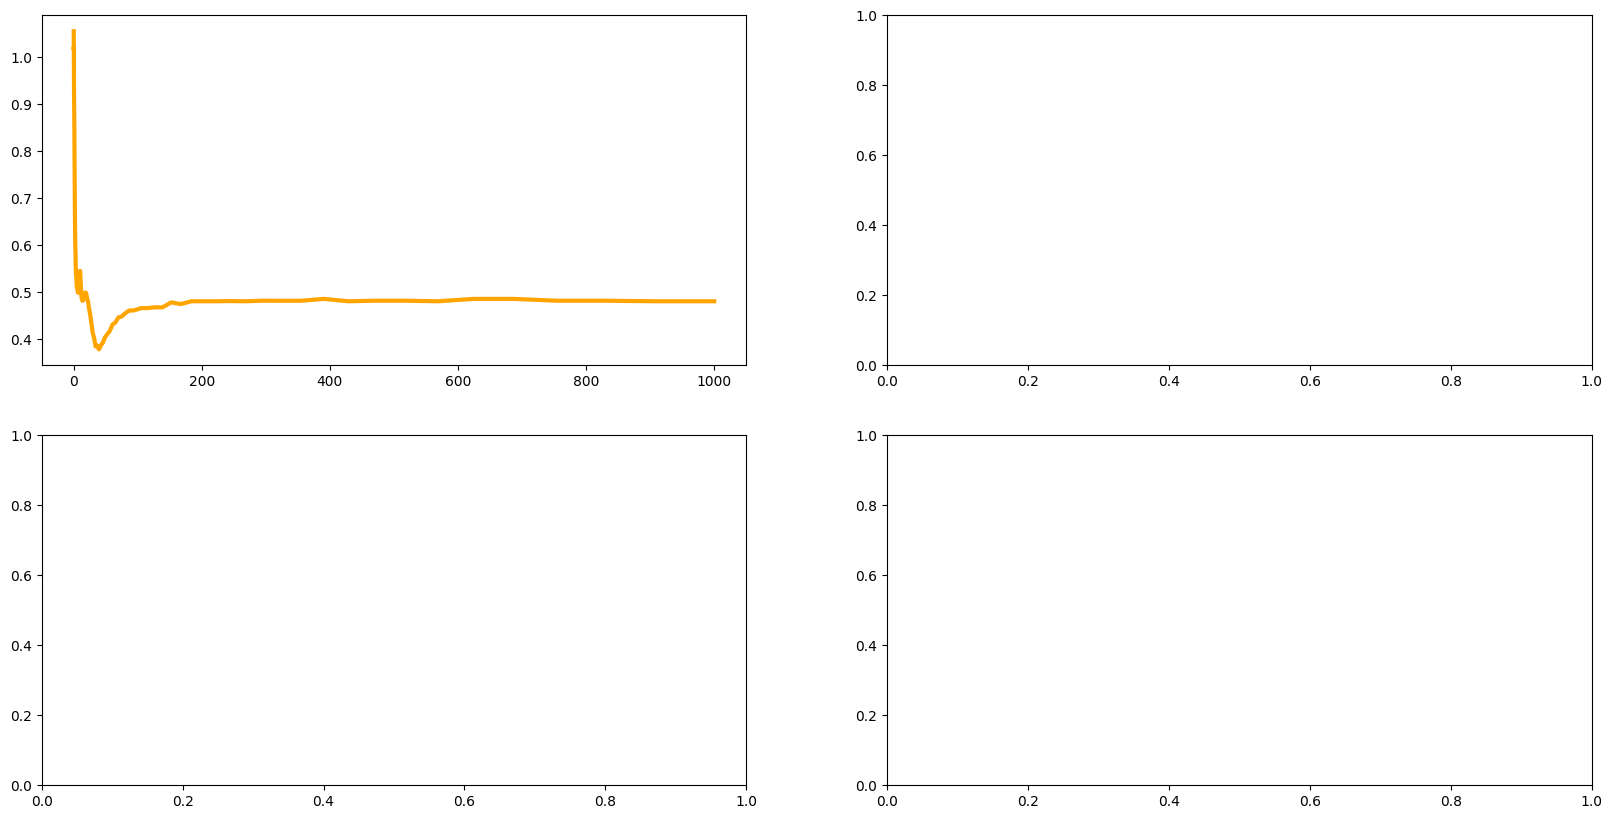

In [16]:
i = 0

while i <24:

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
    ax1.plot(wavelength,test_outputs[i,2,:],color='orange',lw=3,label=f'SKIRT Model: input = {test_inputs[i,0]:2.2f}, {test_inputs[i,1]:2.2f}, {test_inputs[i,2]:2.2f}')
    ax1.plot(wavelength,mean_r_results[:,i],color='green',lw=3,label='Predicted Mean Model')
    ax2.plot(wavelength,test_outputs[i+1,2,:],color='orange',lw=3,label=f'SKIRT Model: input = {test_inputs[i+1,0]:2.2f}, {test_inputs[i+1,1]:2.2f}, {test_inputs[i+1,2]:2.2f}')
    ax2.plot(wavelength,mean_r_results[:,i+1],color='green',lw=3,label='Predicted Mean Model')
    ax3.plot(wavelength,test_outputs[i+2,2,:],color='orange',lw=3,label=f'SKIRT Model: input = {test_inputs[i+2,0]:2.2f}, {test_inputs[i+2,1]:2.2f}, {test_inputs[i+2,2]:2.2f}')
    ax3.plot(wavelength,mean_r_results[:,i+2],color='green',lw=3,label='Predicted Mean Model')
    ax4.plot(wavelength,test_outputs[i+3,2,:],color='orange',lw=3,label=f'SKIRT Model: input = {test_inputs[i+3,0]:2.2f}, {test_inputs[i+3,1]:2.2f}, {test_inputs[i+3,2]:2.2f}')
    ax4.plot(wavelength,mean_r_results[:,i+3],color='green',lw=3,label='Predicted Mean Model')
    


    for ax in fig.get_axes():
        #ax.label_outer()
        ax.set(xlabel=f'Wavelength($\\mu$m)', ylabel='Half Radius')
        ax.set_xscale('log')
        ax.legend()

    plt.tight_layout()

    
    plt.show()
    plt.close()
    
    
    i = i+4


In [ ]:
print(mean_n_results[:,0], test_inputs[0,:])


[-0.70153606 -0.7069949  -0.6999061  -0.69813263 -0.6751679  -0.6671599
 -0.6634392  -0.65057725 -0.67754465 -0.6839571  -0.6867652  -0.65959394
 -0.6385331  -0.6160207  -0.60487443 -0.55514157 -0.5152227  -0.48304754
 -0.43866482 -0.4266083  -0.38131645 -0.36922836 -0.32973087 -0.29531533
 -0.26639763 -0.22256333 -0.19558963 -0.17241569 -0.11842591 -0.0900635
 -0.07988241 -0.06702003 -0.05259467 -0.04881159 -0.03226814 -0.02141795
 -0.00092107  0.02325037  0.06221455  0.07421613  0.09175235  0.12758687
  0.13634059  0.12907492  0.1474641   0.16501002  0.17567632  0.19902483
  0.188966    0.19816981  0.19798742  0.18947819  0.18247378  0.14955065
  0.06471376  0.03842482  0.12589683  0.17235388  0.18842953  0.19698213
  0.21772963  0.22097936  0.2059403   0.22239123  0.2554524   0.3003967
  0.34383044  0.37412044  0.40136516  0.43097824  0.42374223  0.40753677
  0.39610794  0.38823062  0.37212184  0.3424501   0.33056033  0.29903913
  0.27626005  0.25355873  0.22735192  0.20513801  0.18

In [ ]:
print(mean_n_results[:,7], test_inputs[7,:])


[-7.15491474e-01 -7.18201578e-01 -7.10500836e-01 -7.08137631e-01
 -6.84603214e-01 -6.75066948e-01 -6.73128188e-01 -6.60497665e-01
 -6.86533988e-01 -6.92302346e-01 -6.96274400e-01 -6.68639541e-01
 -6.48839653e-01 -6.23640537e-01 -6.12119734e-01 -5.64391017e-01
 -5.22534907e-01 -4.86933947e-01 -4.43564862e-01 -4.29887921e-01
 -3.84206802e-01 -3.71654689e-01 -3.31653535e-01 -2.96765417e-01
 -2.66274303e-01 -2.23801166e-01 -1.96861640e-01 -1.73911676e-01
 -1.16560668e-01 -8.93431827e-02 -8.05314556e-02 -6.63853139e-02
 -5.32890931e-02 -4.73818965e-02 -2.83298902e-02 -2.07102820e-02
 -5.45659976e-04  2.65208278e-02  6.41783401e-02  7.72557780e-02
  9.42928419e-02  1.30434692e-01  1.37397826e-01  1.32313669e-01
  1.50073200e-01  1.67284831e-01  1.79006577e-01  2.02626258e-01
  1.93793491e-01  2.01798558e-01  2.00827301e-01  1.92480057e-01
  1.84433147e-01  1.52682349e-01  6.82494417e-02  4.17560637e-02
  1.27857357e-01  1.77388728e-01  1.90614477e-01  2.00456977e-01
  2.20717326e-01  2.23428

In [ ]:
mean_f_results, std_f_results = BNN(0.3, train_inputs, train_outputs[:,1,:], 2000, 0.01, test_inputs, test_outputs[:,1,:] )


TypeError: BNN() missing 1 required positional argument: 'output_test'

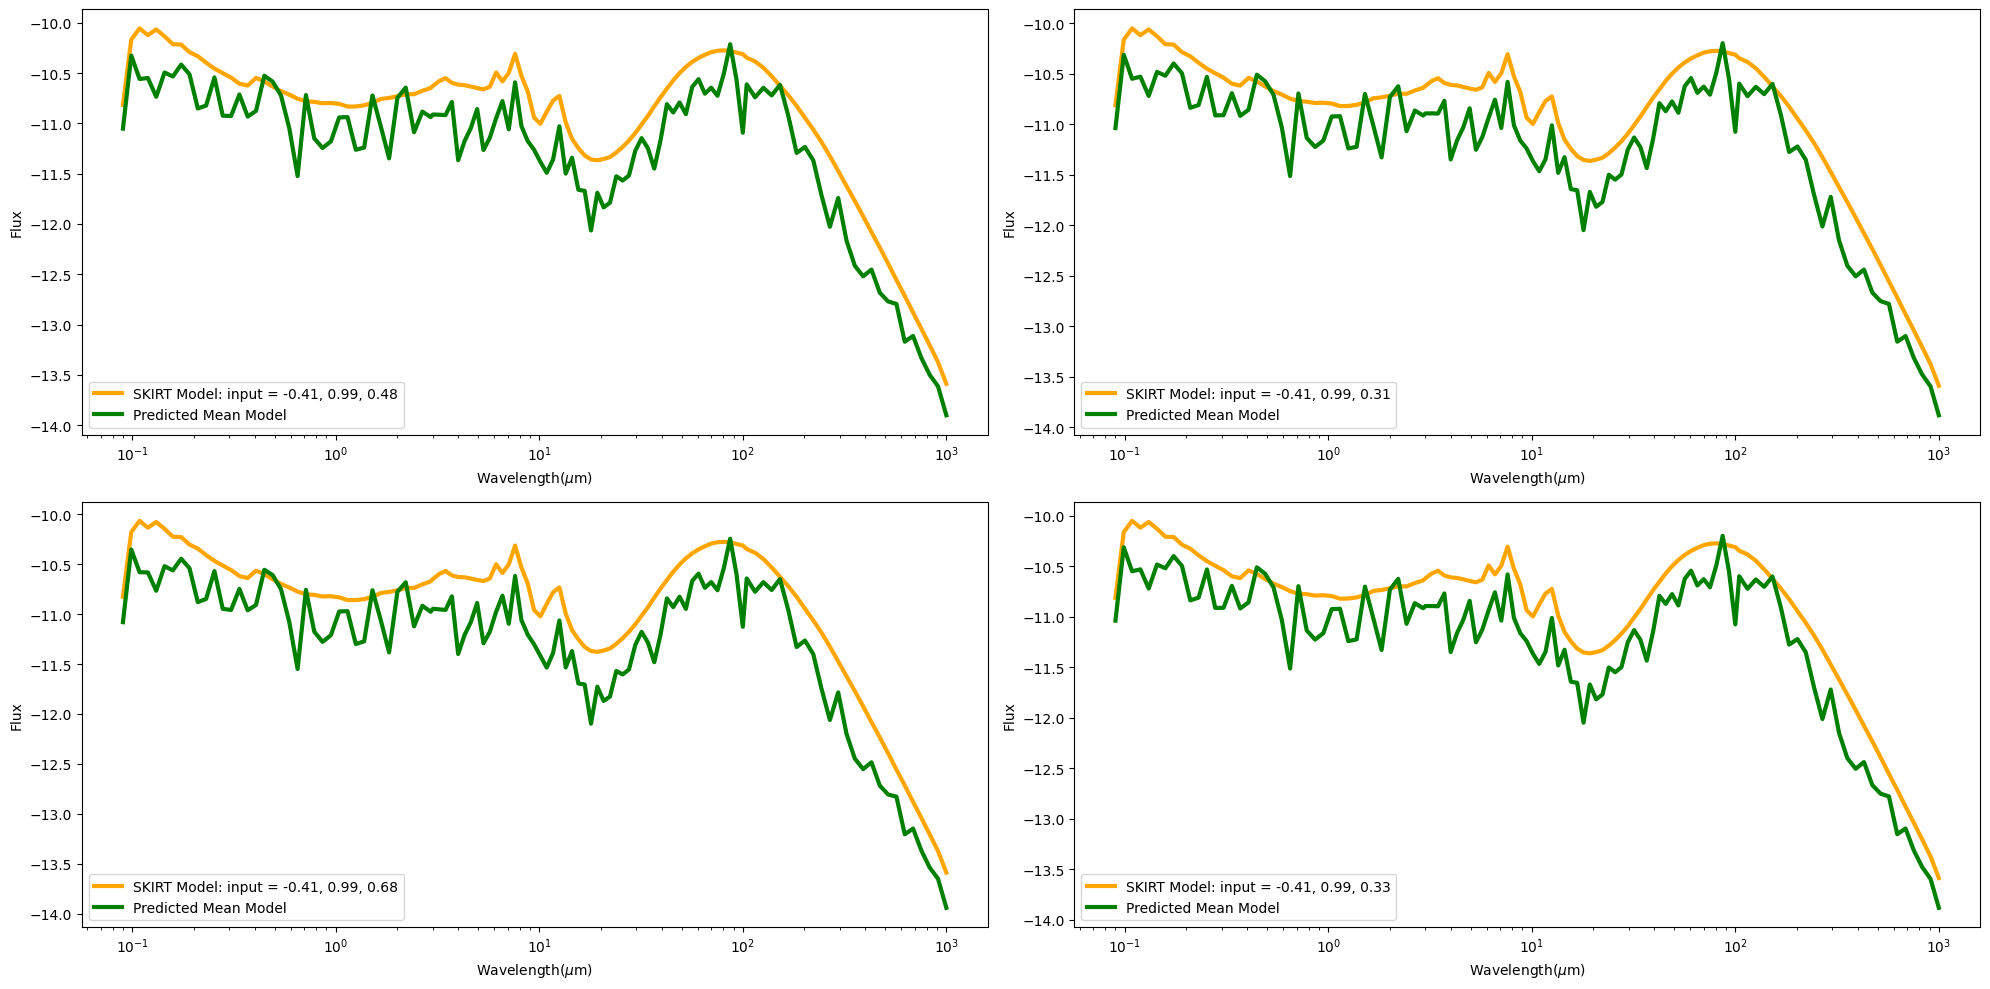

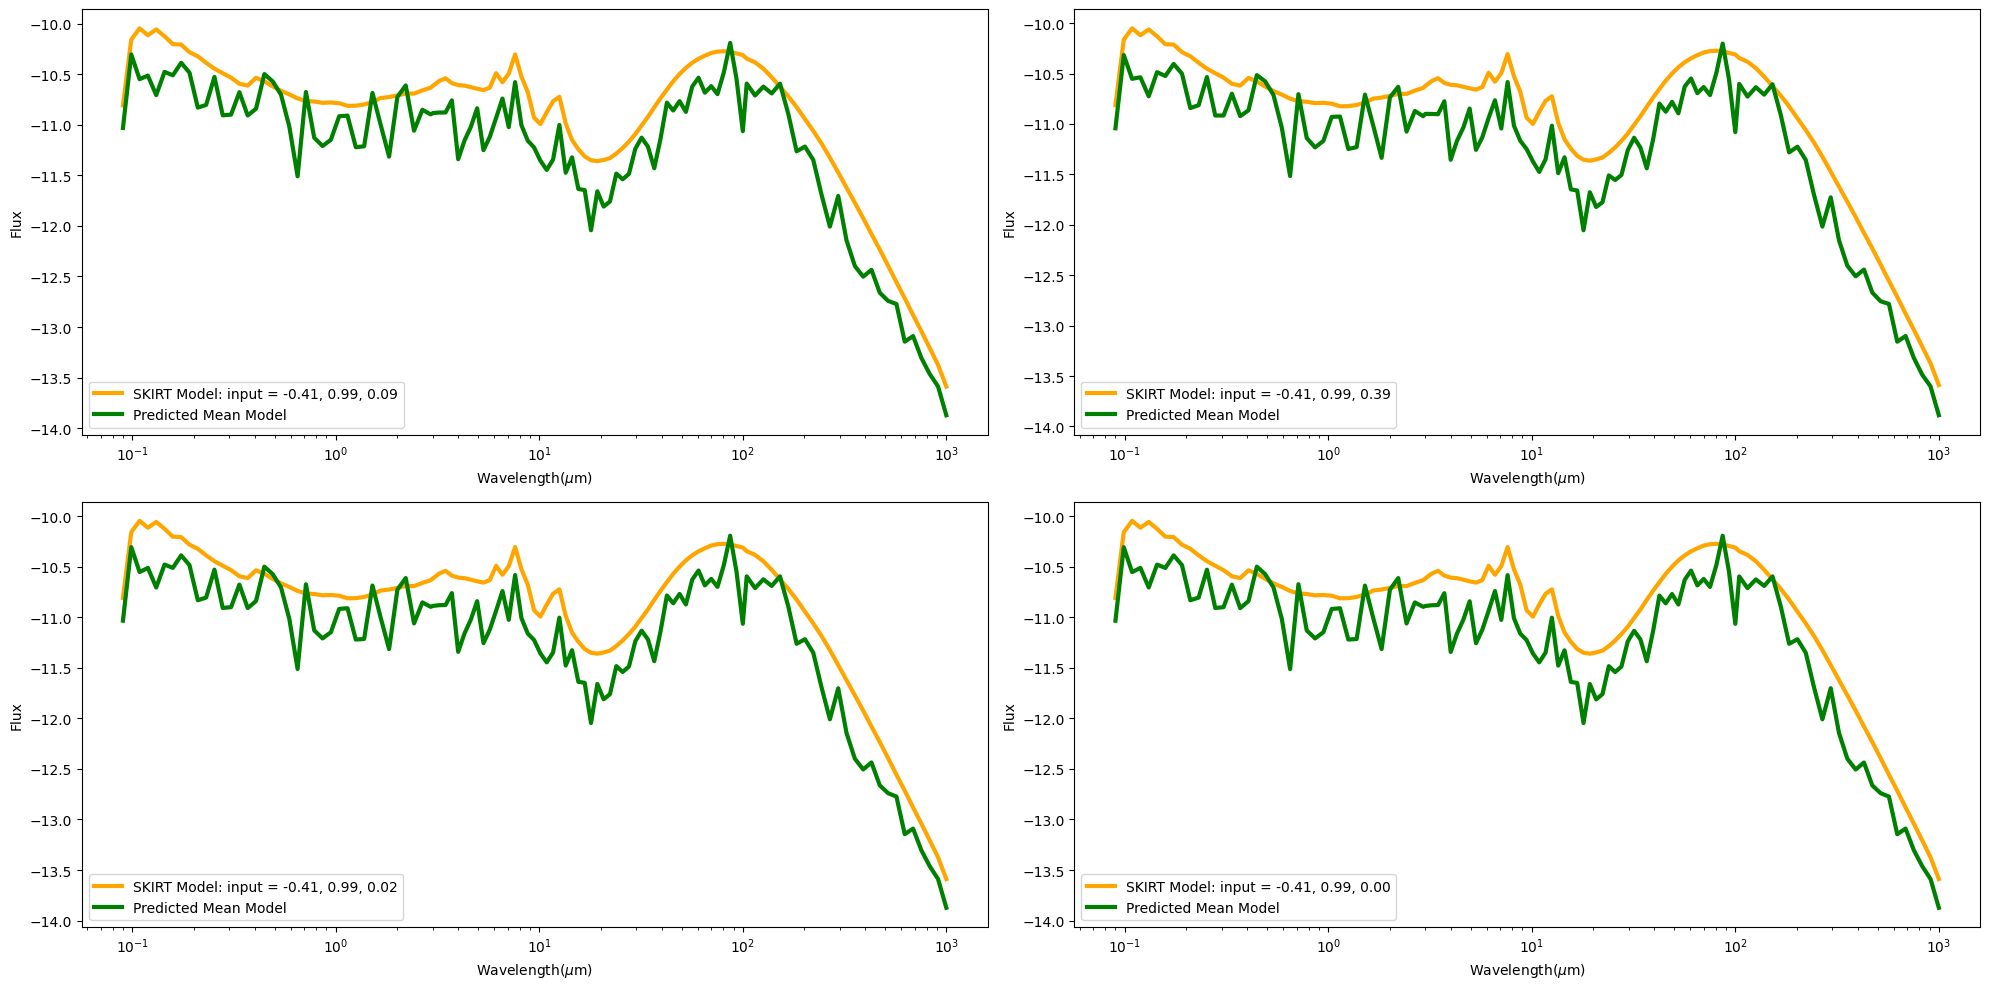

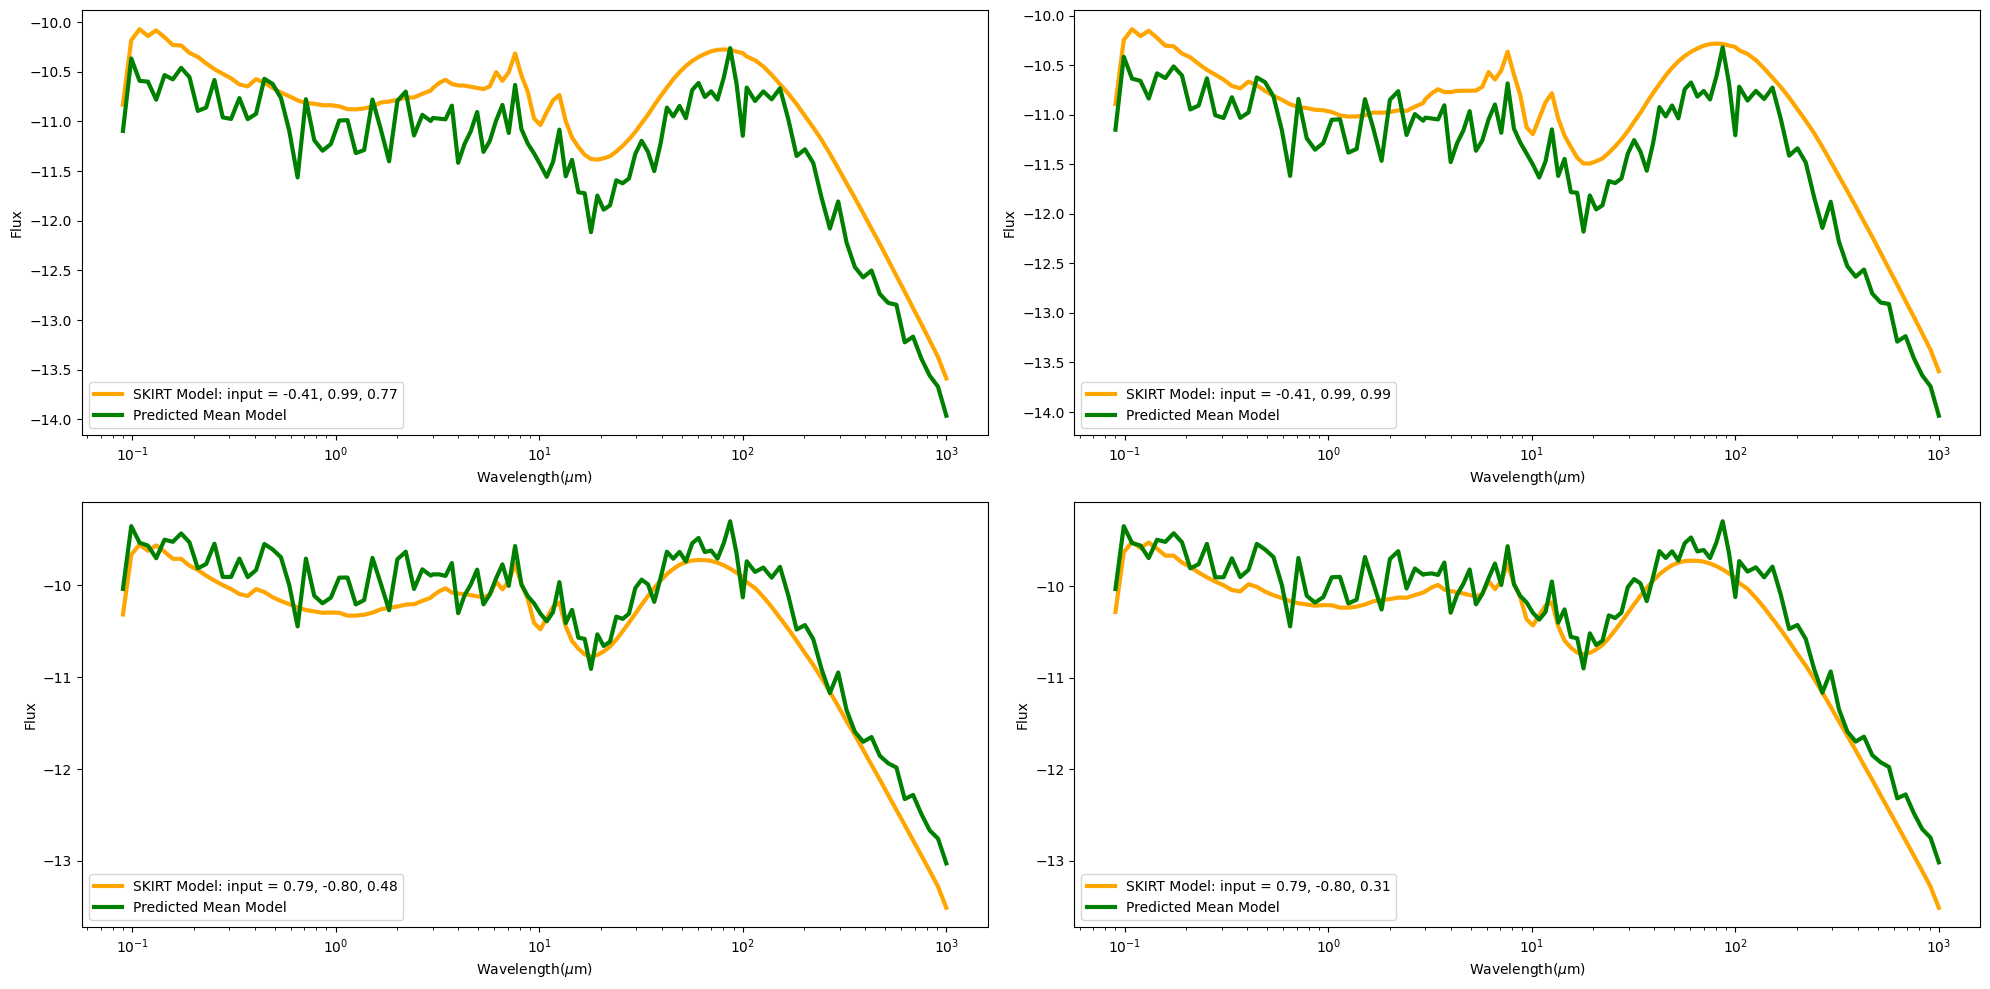

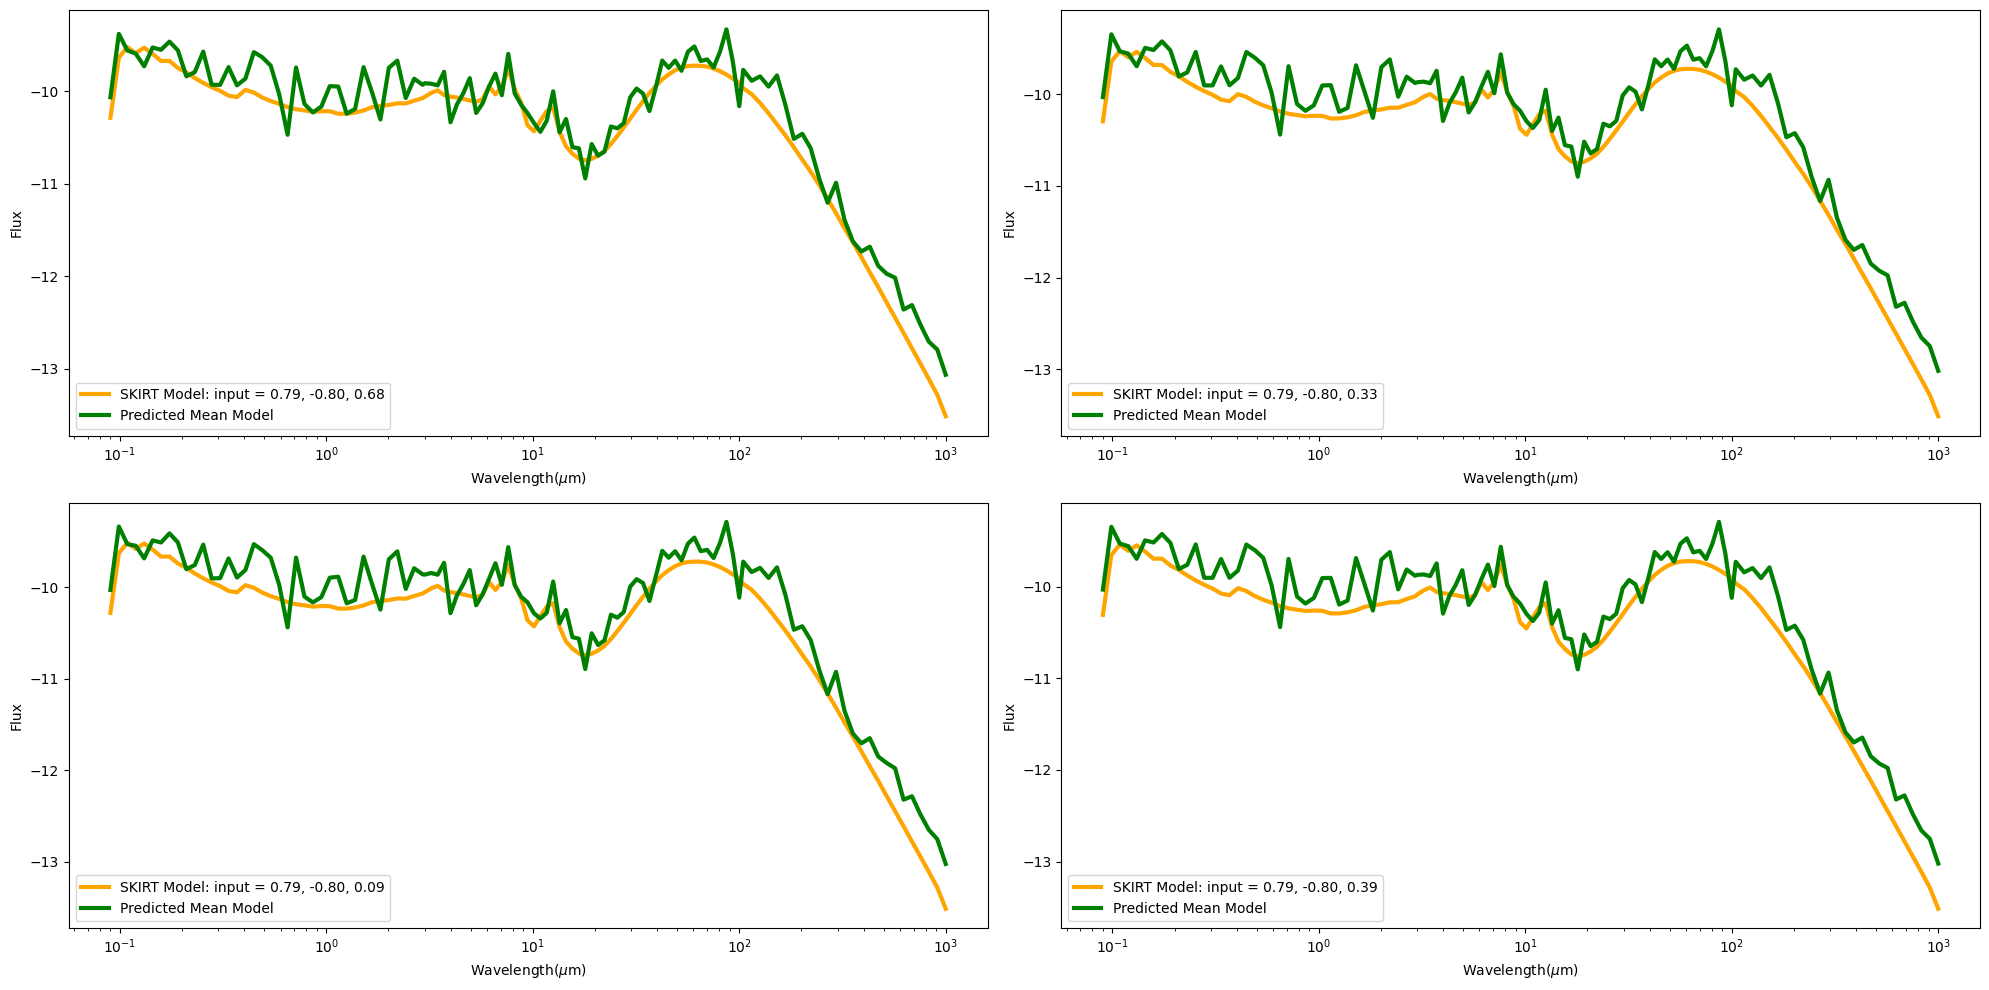

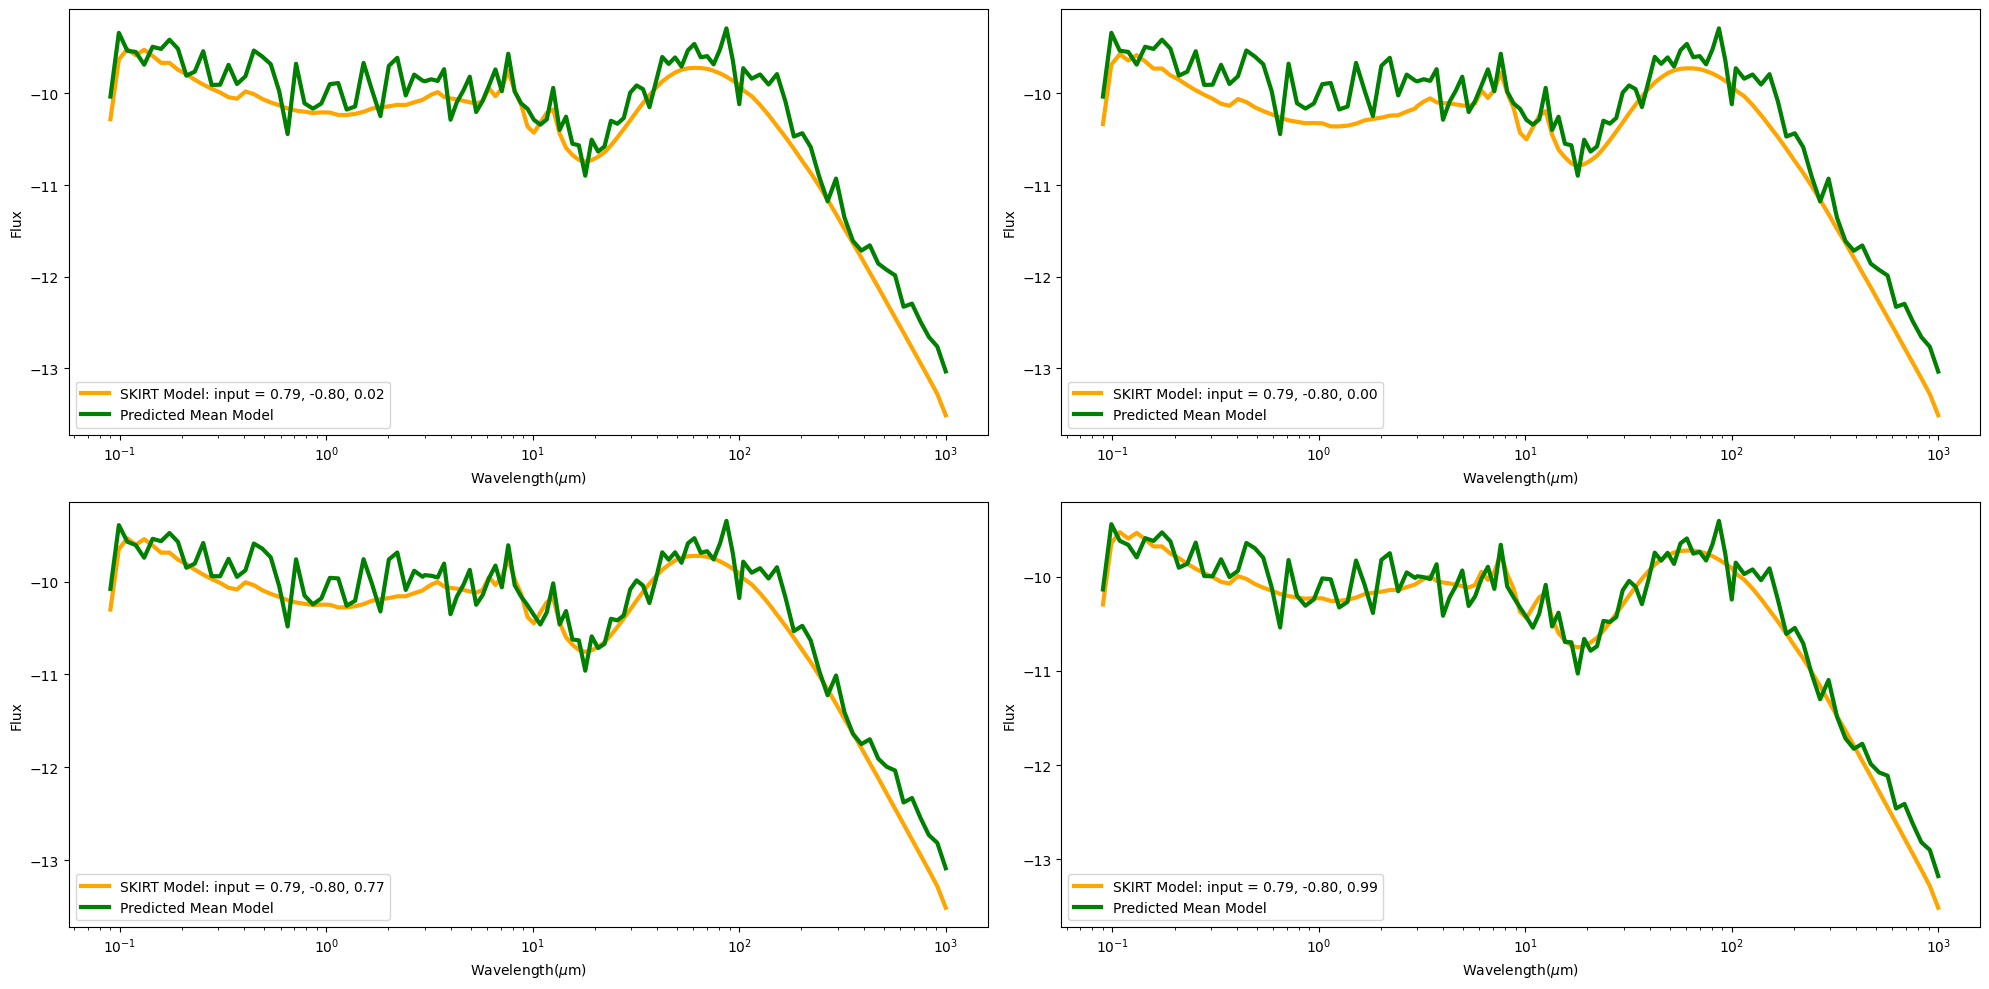

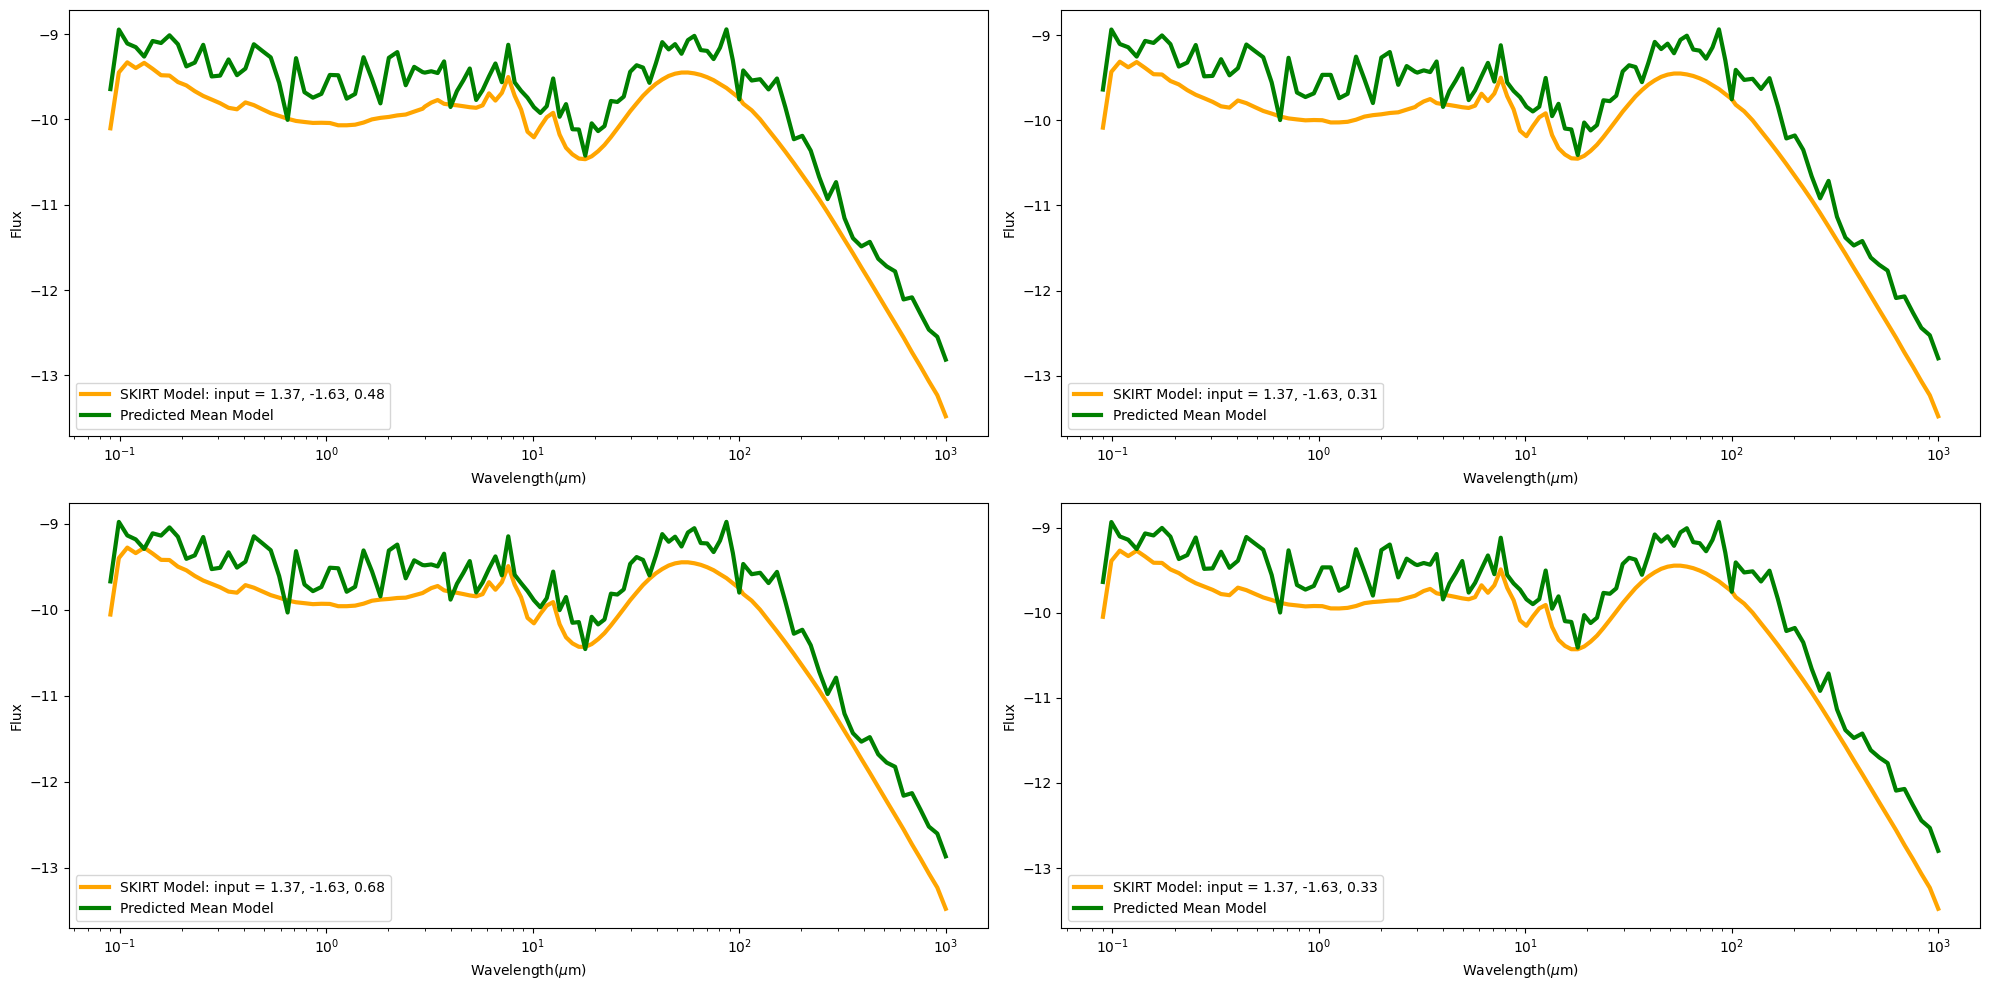

In [ ]:
i = 0

while i <24:

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
    ax1.plot(wavelength,test_outputs[i,1,:],color='orange',lw=3,label=f'SKIRT Model: input = {test_inputs[i,0]:2.2f}, {test_inputs[i,1]:2.2f}, {test_inputs[i,2]:2.2f}')
    ax1.plot(wavelength,mean_f_results[:,i],color='green',lw=3,label='Predicted Mean Model')
    ax2.plot(wavelength,test_outputs[i+1,1,:],color='orange',lw=3,label=f'SKIRT Model: input = {test_inputs[i+1,0]:2.2f}, {test_inputs[i+1,1]:2.2f}, {test_inputs[i+1,2]:2.2f}')
    ax2.plot(wavelength,mean_f_results[:,i+1],color='green',lw=3,label='Predicted Mean Model')
    ax3.plot(wavelength,test_outputs[i+2,1,:],color='orange',lw=3,label=f'SKIRT Model: input = {test_inputs[i+2,0]:2.2f}, {test_inputs[i+2,1]:2.2f}, {test_inputs[i+2,2]:2.2f}')
    ax3.plot(wavelength,mean_f_results[:,i+2],color='green',lw=3,label='Predicted Mean Model')
    ax4.plot(wavelength,test_outputs[i+3,1,:],color='orange',lw=3,label=f'SKIRT Model: input = {test_inputs[i+3,0]:2.2f}, {test_inputs[i+3,1]:2.2f}, {test_inputs[i+3,2]:2.2f}')
    ax4.plot(wavelength,mean_f_results[:,i+3],color='green',lw=3,label='Predicted Mean Model')
    


    for ax in fig.get_axes():
        #ax.label_outer()
        ax.set(xlabel=f'Wavelength($\\mu$m)', ylabel='Flux')
        ax.set_xscale('log')
        ax.legend()

    plt.tight_layout()

    
    plt.show()
    plt.close()
    
    
    i = i+4
